# GBM in Azure ML Jupyter Notebook
Lixun Zhang  
Nov 10, 2015

## 1 Introduction
Before starting this example, it is assumed that you are familiar with Azure Machine Learning (Azure ML) experiments. If not, you can refer to [Data Scientists' Guide][guide link]. 

The purpose of this example is to demonstrate how to use Azure ML Jupyter notebook to fit a Gradient Boosting Machine (GBM) model.

GBM is well-known among data scientists and as a [Kaggle Profile][kaggle link] explains, it has several major advantages compared with traditional statistical models like linear regression:
    1. it automatically approximates non-linear transformations and interactions
    2. it treats missing values without having to fill in values or remove observations
    3. monotonic transformation of features won't influence the model's performance

In an Azure ML experiment, we can use the "Boosted Decision Tree Regression" module to fit a GBM model when the response variable is continuous. This module, however, does not allow users to specify the types of loss functions (for statisticians, this means that you can't specify the distribution for the response variable). One way to address this challenge is to make use of the [sklearn][sklearn link] package for Python. In what follows we'll illustrate how to do this within an Azure ML Jupyter notebook. 

[guide link]: https://gallery.cortanaanalytics.com/Experiment/Tutorial-for-Data-Scientists-3
[kaggle link]: http://blog.kaggle.com/2015/06/22/profiling-top-kagglers-owen-zhang-currently-1-in-the-world/
[sklearn link]: http://scikit-learn.org/stable/index.html

## 2 Read Data
Following the same procedure as [Tutorial for Using Azure Machine Learning Notebook][tutorial link], we'll read data from an experiment with the following code.

[tutorial link]: link

In [10]:
from azureml import Workspace
ws = Workspace(
 workspace_id='b2bbeb56a1d04e1599d2510a06c59d87',
 authorization_token=<token>,
 endpoint='https://studioapi.azureml.net'
)
experiment = ws.experiments['b2bbeb56a1d04e1599d2510a06c59d87.\
f-id.911630d13cbe4407b9fe408b5bb6ddef']
ds = experiment.get_intermediate_dataset(
 node_id='a0a931cf-9fb3-4cb9-83db-f48211be560c-323',
 port_name='Results dataset',
 data_type_id='GenericCSV'
)
frame = ds.to_dataframe()

mydata = frame

## 3 Estimate Hyperparameters
In a GBM model, there are several hyperparameters and we need to estimate them first. One way to estimate these parameters is to use cross validation on a parameter-grid. In our example, we'll optimize the following parameters over a grid: number of estimators, maximum tree depth, minimum number of samples on a split, and learning rate. To do this we start by providing several values for each of them and create a set of combinations, each combination consisting of one value for each parameter. Then for each combination we use cross validation to estimate the performance, using mean squared error as performance metric.

[gbm link]: https://gradientboostedmodels.googlecode.com/git/gbm/inst/doc/gbm.pdf

In [14]:
# create X and y
feature_cols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 
                'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']
X = mydata[feature_cols]
y = mydata.medv

#%% use cross validation to estimate hyperparameters on a grid
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from time import time

tuned_params = {'n_estimators': [500, 1000, 10000], 
                'max_depth': [2, 4, 8], 
                'min_samples_split': [1, 2, 4],
                'learning_rate': [0.001, 0.01, 0.1]}
          
print("# Tuning hyper-parameters for mean_squared_error")

gscv = GridSearchCV(GradientBoostingRegressor(loss = 'ls', random_state=0), 
                    tuned_params, cv=5, scoring='mean_squared_error')

start = time()
gscv.fit(X, y)
print("The grid cross validation lasted {0:0.2f} seconds"
      .format(time() - start))
print("Best parameters set found on development set:")
print(gscv.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in gscv.grid_scores_:
    print("{0:0.3f} (+/-{1:0.3f}) for {2:s}"
          .format(mean_score, scores.std() * 2, params))

# Tuning hyper-parameters for mean_squared_error
The grid cross validation lasted 865.39 seconds
Best parameters set found on development set:
{'min_samples_split': 4, 'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 2}
Grid scores on development set:
-58.797 (+/-51.215) for {'min_samples_split': 1, 'n_estimators': 500, 'learning_rate': 0.001, 'max_depth': 2}
-41.242 (+/-40.364) for {'min_samples_split': 1, 'n_estimators': 1000, 'learning_rate': 0.001, 'max_depth': 2}
-18.555 (+/-25.300) for {'min_samples_split': 1, 'n_estimators': 10000, 'learning_rate': 0.001, 'max_depth': 2}
-58.797 (+/-51.215) for {'min_samples_split': 2, 'n_estimators': 500, 'learning_rate': 0.001, 'max_depth': 2}
-41.242 (+/-40.364) for {'min_samples_split': 2, 'n_estimators': 1000, 'learning_rate': 0.001, 'max_depth': 2}
-18.555 (+/-25.300) for {'min_samples_split': 2, 'n_estimators': 10000, 'learning_rate': 0.001, 'max_depth': 2}
-58.797 (+/-51.215) for {'min_samples_split': 4, 'n_estimators': 500, 'lear

## 4 Fit Model with Estimated Parameters
With the selected parameter values from above, we can fit a GBM model and check model performance. A plot comparing the importance of variables is also generated. 

Mean Absolute Error: 0.844351
Root Mean Squared Error: 1.071576
Relative Absolute Error: 0.127023
Relative Squared Error: 0.013602


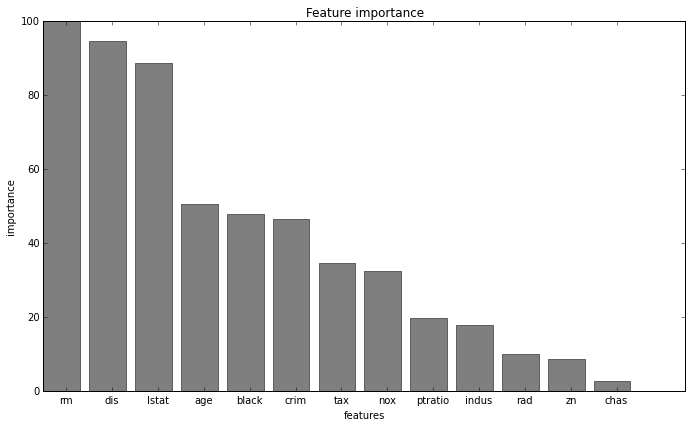

In [9]:
%matplotlib inline

# fit model with the best set of parameter values
params = {'n_estimators': 500, 'max_depth': 2, 'min_samples_split': 4,
          'learning_rate': 0.1, 'loss': 'ls', 'random_state': 0}
          
gbm = GradientBoostingRegressor(**params)

gbm.fit(X, y)

# check additional performance metrics
# assign test data
import pandas as pd
newX = X
newY = y

# join predictions with original data
predicted = gbm.predict(newX)
predicted_df = pd.DataFrame({"predicted": predicted})
mydata_with_pd = newX.join(newY).join(predicted_df)
mydata_with_pd.head()

# check performance metrics
import numpy as np
obs = mydata_with_pd.medv
pred = mydata_with_pd.predicted

mae = np.mean(abs(pred-obs))
rmse = np.sqrt(np.mean((pred-obs)**2))
rae = np.mean(abs(pred-obs))/np.mean(abs(obs-np.mean(obs)))
rse = np.mean((pred-obs)**2)/np.mean((obs-np.mean(obs))**2)

# print additional performance metrics
print("Mean Absolute Error: {0:0.6f}".format(mae))
print("Root Mean Squared Error: {0:0.6f}".format(rmse))
print("Relative Absolute Error: {0:0.6f}".format(rae))
print("Relative Squared Error: {0:0.6f}".format(rse))

# plot variable importance
import numpy as np
import matplotlib.pyplot as plt

feature_importance = gbm.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(feature_cols))
bar_width = 0.5
plt.bar(index, feature_importance[sorted_idx], color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index + bar_width, np.array(feature_cols)[sorted_idx])
plt.tight_layout()
plt.show()


## 5 Conclusion
Using the Boston housing dataset, we started the analysis by estimating the parameters in the GBM model. Then we fitted the model and examined variable importance. 

In addition to the least squares (ls) loss function, [GradientBoostingRegressor][boostingreg link] from [sklearn][sklearn link] allows for several other loss functions: least absolute deviation (lad), huber loss function which is a combination of ls and lad, and quantile loss function. For example, the least squares loss function is commonly used when the response variable follows a Gaussian distribution and the least absolute deviation loss function is appropriate when the response variable follows a Laplace distribution. 


[boostingreg link]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
[sklearn link]: http://scikit-learn.org/stable/index.html